In [ ]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [ ]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_body_features, num_face_features):
    super(Emotic,self).__init__()
    self.num_body_features = num_body_features
    self.num_face_features = num_face_features
    self.fc1 = nn.Linear((self.num_body_features + self.num_face_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_body, x_face):
    body_features = x_body.view(-1, self.num_body_features)
    face_features = x_face.view(-1, self.num_face_features)
    fuse_features = torch.cat((body_features, face_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_body, x_face, y_cat, y_cont, transform, body_norm, face_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.body_norm(self.transform(image_body)), self.face_norm(self.transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [ ]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [ ]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''

train_face =  np.stack((np.load(os.path.join(data_src,'pre','train_face_arr.npy')),) * 3, axis=-1)
val_face = np.stack((np.load(os.path.join(data_src,'pre','val_face_arr.npy')),) * 3, axis=-1)
test_face = np.stack((np.load(os.path.join(data_src,'pre','test_face_arr.npy')),) * 3, axis=-1)

#salieny train
train_body = np.load(os.path.join(data_src,'pre', saliency_method + 'train_body_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#salieny val
val_body = np.load(os.path.join(data_src,'pre',saliency_method + 'val_body_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#salieny test
test_body = np.load(os.path.join(data_src,'pre',saliency_method + 'test_body_arr.npy'))

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'body ', train_body.shape, 'body', train_face.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'body ', val_body.shape, 'body', val_face.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'body ', test_body.shape, 'body', test_face.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  body  (23266, 128, 128, 3) body (23266, 48, 48, 3) cat  (23266, 26) cont (23266, 3)
val  body  (3315, 128, 128, 3) body (3315, 48, 48, 3) cat  (3315, 26) cont (3315, 3)
test  body  (7203, 128, 128, 3) body (7203, 48, 48, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [ ]:
batch_size = 26

body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_body, train_face, train_cat, train_cont, \
                                  train_transform, body_norm, face_norm)
val_dataset = Emotic_PreDataset(val_body, val_face, val_cat, val_cont, \
                                test_transform, body_norm, face_norm)
test_dataset = Emotic_PreDataset(test_body, test_face, test_cat, test_cont, \
                                 test_transform, body_norm, face_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE EMOTIC MODEL

## Resnet-18 (ImageNet)

In [ ]:
model_body = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.3MB/s]


## Resnet-50 (ImageNet)

In [ ]:
model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

## SwinT (ImageNet)

In [ ]:
model_body = models.swin_t(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 76.4MB/s]


In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_body, x_face, y_cat, y_cont, transform, body_norm, face_norm, face_transform):
    super(Emotic_PreDataset,self).__init__()
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

In [ ]:
batch_size = 26

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_body, train_face, train_cat, train_cont, \
                                  train_transform, body_norm, face_norm, face_train_transform)
val_dataset = Emotic_PreDataset(val_body, val_face, val_cat, val_cont, \
                                test_transform, body_norm, face_norm, face_test_transform)
test_dataset = Emotic_PreDataset(test_body, test_face, test_cat, test_cont, \
                                 test_transform, body_norm, face_norm, face_test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

# VI. Prepare Model + Optimizer

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_body.children())[-1].in_features, 256)
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_body.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


## FER-2013

In [ ]:
def test_data(models, device, data_loader, num_images):
    model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_body.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_body = images_body.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_body.to(device)
    model_face.to(device)

    emotic_model.train()
    model_body.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_body = images_body.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_body = model_body(images_body)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_body.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_body = images_body.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_body = model_body(images_body)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 447566.7689
vad [1.6943887 2.0108545 2.0014641] (3,) 1.9022356
epoch = 0 training MAE = 1.9022
epoch = 0 validation loss = 11468.0326
vad [0.9012193 0.9534712 0.8871358] (3,) 0.9139421
epoch = 0 val MAE= 0.9139
saving model at epoch e = 0
epoch = 1 training loss = 240182.2726
vad [1.1936274 1.7167144 1.5794897] (3,) 1.4966105
epoch = 1 training MAE = 1.4966
epoch = 1 validation loss = 12351.3181
vad [0.8470786 0.9953556 0.9589897] (3,) 0.9338079
epoch = 1 val MAE= 0.9338
epoch = 2 training loss = 226627.0744
vad [1.130184  1.6886009 1.5300838] (3,) 1.449623
epoch = 2 training MAE = 1.4496
epoch = 2 validation loss = 9633.2811
vad [0.78193134 0.88807845 0.85415244] (3,) 0.84138745
epoch = 2 val MAE= 0.8414
saving model at epoch e = 2
epoch = 3 training loss = 218370.8974
vad [1.1074854 1.666027  1.4915164] (3,) 1.4216763
epoch = 3 training MAE = 1.4217
epoch = 3 validation loss = 11995.4722
vad [0.763005  0.9091014 1.0709195] (3,) 0.914342
epoch = 3 val MAE= 0.

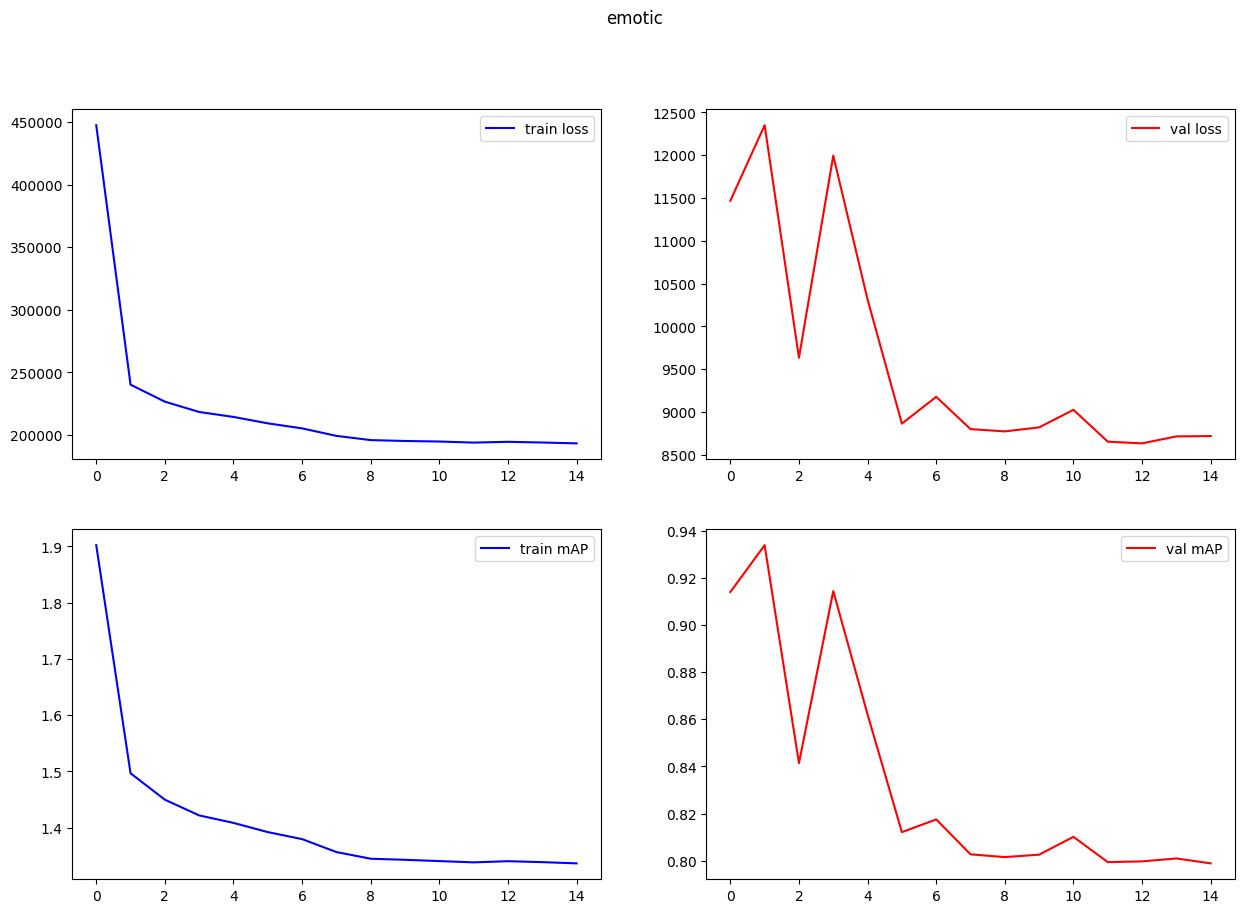

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [ ]:
model_path = './models'
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.87382674 1.0413202  0.94846314] (3,) 0.9545367
0.9545367
testing MAE=0.9545


# **Train 2 (Resnet-50)**

---



## Resnet-50 (ImageNet)

In [ ]:
model_body = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.1MB/s]


## Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 46, 46]              80
       BatchNorm2d-2            [-1, 8, 46, 46]              16
         MaxPool2d-3            [-1, 8, 45, 45]               0
              ReLU-4            [-1, 8, 45, 45]               0
            Conv2d-5           [-1, 16, 43, 43]           1,168
           Dropout-6           [-1, 16, 43, 43]               0
       BatchNorm2d-7           [-1, 16, 43, 43]              32
         MaxPool2d-8           [-1, 16, 42, 42]               0
              ReLU-9           [-1, 16, 42, 42]               0
           Conv2d-10           [-1, 32, 40, 40]           4,640
      BatchNorm2d-11           [-1, 32, 40, 40]              64
        MaxPool2d-12           [-1, 32, 39, 39]               0
             ReLU-13           [-1, 32, 39, 39]               0
           Conv2d-14           [-1, 64,

# VI. Prepare Model + Optimizer

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_body.children())[-1].in_features, 256)
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_body.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


## FER-2013

In [ ]:
def test_data(models, device, data_loader, num_images):
    model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_body.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_body = images_body.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_body.to(device)
    model_face.to(device)

    emotic_model.train()
    model_body.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_body = images_body.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_body = model_body(images_body)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_body.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_body = images_body.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_body = model_body(images_body)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

epoch = 0 training loss = 489386.6914
vad [1.6696938 2.162161  2.0668197] (3,) 1.9662248
epoch = 0 training MAE = 1.9662
epoch = 0 validation loss = 14744.7844
vad [0.89883226 1.1367825  1.0085729 ] (3,) 1.0147291
epoch = 0 val MAE= 1.0147
saving model at epoch e = 0
epoch = 1 training loss = 244255.2068
vad [1.2005385 1.7076311 1.6040878] (3,) 1.5040859
epoch = 1 training MAE = 1.5041
epoch = 1 validation loss = 11051.6948
vad [0.84681    0.98130697 0.8672616 ] (3,) 0.8984595
epoch = 1 val MAE= 0.8985
saving model at epoch e = 1
epoch = 2 training loss = 229122.7082
vad [1.1404985 1.6802437 1.5473577] (3,) 1.4560332
epoch = 2 training MAE = 1.4560
epoch = 2 validation loss = 12019.9764
vad [0.78661907 0.88662815 1.0952168 ] (3,) 0.92282134
epoch = 2 val MAE= 0.9228
epoch = 3 training loss = 219217.8067
vad [1.1177813 1.6555591 1.5121745] (3,) 1.428505
epoch = 3 training MAE = 1.4285
epoch = 3 validation loss = 9909.4472
vad [0.7732872 0.9019732 0.8754907] (3,) 0.8502503
epoch = 3 val 

In [ ]:
model_path = './models'
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

# **Train 3 (SwinT)**

---



## SwinT (ImageNet)

In [ ]:
model_body = models.swin_t(weights = 'DEFAULT')

In [ ]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_body, x_face, y_cat, y_cont, transform, body_norm, face_norm, face_transform):
    super(Emotic_PreDataset,self).__init__()
    self.x_body = x_body
    self.x_face = x_face
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.face_transform = face_transform
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])
    self.face_norm = transforms.Normalize(face_norm[0], face_norm[1])

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_body = self.x_body[index]
    image_face = self.x_face[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.body_norm(self.transform(image_body)), self.face_norm(self.face_transform(image_face)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

In [ ]:
batch_size = 26

body_mean = [0.485, 0.456, 0.406]
body_std = [0.229, 0.224, 0.225]

face_mean = [0.507395516207, 0.507395516207, 0.507395516207]
face_std = [0.255128989415, 0.255128989415, 0.255128989415]

body_norm = [body_mean, body_std]
face_norm = [face_mean, face_std]

train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])


test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(size=[232], interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.CenterCrop(size=[224]),
                                     transforms.ToTensor()])

face_train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

face_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_body, train_face, train_cat, train_cont, \
                                  train_transform, body_norm, face_norm, face_train_transform)
val_dataset = Emotic_PreDataset(val_body, val_face, val_cat, val_cont, \
                                test_transform, body_norm, face_norm, face_test_transform)
test_dataset = Emotic_PreDataset(test_body, test_face, test_cat, test_cont, \
                                 test_transform, body_norm, face_norm, face_test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

## Face Recognition FER2013

In [ ]:
face_model_path = "/content/drive/MyDrive/VA-prediction/models/FER_trained_model.pt"

In [ ]:
import torch.nn as nn
import torch

class Face_Emotion_CNN(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 7)
    self.dropout = nn.Dropout(0.3)
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.relu(self.dropout(self.fc2(x)))
    x = self.log_softmax(self.fc3(x))
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def load_trained_model(model_path):
    model = Face_Emotion_CNN()
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
    return model

In [ ]:
model_face = load_trained_model(face_model_path)

In [ ]:
print(summary(model_face, (1, 48,48), device="cpu"))

In [ ]:
class Face_Emotion_CNN_new(nn.Module):
  def __init__(self):
    super(Face_Emotion_CNN_new, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
    self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
    self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
    self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
    self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2, 1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.cnn1_bn = nn.BatchNorm2d(8)
    self.cnn2_bn = nn.BatchNorm2d(16)
    self.cnn3_bn = nn.BatchNorm2d(32)
    self.cnn4_bn = nn.BatchNorm2d(64)
    self.cnn5_bn = nn.BatchNorm2d(128)
    self.cnn6_bn = nn.BatchNorm2d(256)
    self.cnn7_bn = nn.BatchNorm2d(256)
    self.fc1 = nn.Linear(1024, 512)
    self.fc2 = nn.Linear(512, 256)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.pool1(self.cnn1_bn(self.cnn1(x))))
    x = self.relu(self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x)))))
    x = self.relu(self.pool1(self.cnn3_bn(self.cnn3(x))))
    x = self.relu(self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x)))))
    x = self.relu(self.pool2(self.cnn5_bn(self.cnn5(x))))
    x = self.relu(self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x)))))
    x = self.relu(self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x)))))

    x = x.view(x.size(0), -1)

    x = self.relu(self.dropout(self.fc1(x)))
    x = self.fc2(x)
    return x

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
state_dict = model_face.state_dict()
del state_dict['fc3.weight']
del state_dict['fc3.bias']

In [ ]:
model_face_new = Face_Emotion_CNN_new()

In [ ]:
model_face_new.load_state_dict(state_dict)

In [ ]:
print(summary(model_face_new, (1, 48,48), device="cpu"))

# VI. Prepare Model + Optimizer

In [ ]:
model_face = model_face_new
emotic_model = Emotic(list(model_body.children())[-1].in_features, 256)
model_body = nn.Sequential(*(list(model_body.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_body.parameters():
  param.requires_grad = False
for param in model_face.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_body.parameters()) + \
                  list(model_face.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

# VII. Train + Test Function

In [ ]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

## FER-2013

In [ ]:
def test_data(models, device, data_loader, num_images):
    model_body, model_face, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_body.to(device)
        model_face.to(device)
        emotic_model.to(device)
        model_body.eval()
        model_face.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_body, images_face, labels_cat, labels_cont in iter(data_loader):
            images_body = images_body.to(device)
            images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)

            pred_body = model_body(images_body)
            pred_face = model_face(images_face)
            pred_cont = emotic_model(pred_body, pred_face)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

In [ ]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_body, model_face, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_body.to(device)
    model_face.to(device)

    emotic_model.train()
    model_body.train()
    model_face.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_body, images_face, labels_cat, labels_cont in iter(train_loader):
      images_body = images_body.to(device)
      images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_body = model_body(images_body)
      pred_face = model_face(images_face)

      pred_cont = emotic_model(pred_body, pred_face)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_body.eval()
    model_face.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_body, images_face, labels_cat, labels_cont in iter(val_loader):
        images_body = images_body.to(device)
        images_face = torch.mean(images_face, dim=1, keepdim=True).to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_body = model_body(images_body)
        pred_face = model_face(images_face)

        pred_cont = emotic_model(pred_body, pred_face)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_body.to("cpu")
        model_face.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body.pth'))
        torch.save(model_face, os.path.join(model_path, 'model_face.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

# VIII. Training + Testing

In [ ]:
train_emotic(15, './models', opt, scheduler, [model_body, model_face, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [ ]:
model_path = './models'
model_body = torch.load(os.path.join(model_path, 'model_body.pth'))
model_face = torch.load(os.path.join(model_path, 'model_face.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_body.eval()
model_face.eval()
emotic_model.eval()

print ('completed cell')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_vad = test_data([model_body, model_face, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))